# How to calculate and visualize Aerosol Optical Depths (AOD) from MISR

## Summary

This code graphs Aerosol Optical Depths (AOD) from the Multi-angle Imaging SpectroRadiometer (MISR) instrument.

## Prerequisites

A free(!) account at https://www.earthdata.nasa.gov/ is needed to login and download the appropriate files.

This notebook was tested last using Python 3.10.15, and requires these libraries:

- [cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/)
- [h5py](https://docs.h5py.org/en/stable/index.html)
- [matplotlib](http://matplotlib.org/)
- [numpy](https://numpy.org/)

### Notebook Author / Affiliation

By Cheyenne Land, Walt Baskin / Atmospheric Science Data Center

## 1. Setup

In [1]:
import cartopy.crs as ccrs
import earthaccess
import h5py
import numpy as np
from matplotlib import pyplot as plt

## 2. Search for data using earthaccess

We use `earthaccess` to streamline the login to NASA Earthdata. 

<details open>
  <summary><i>Additional resources about earthaccess</i></summary>

- [*earthaccess* documentation](https://earthaccess.readthedocs.io/en/latest/)
- [Earthdata Cloud Cookbook](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/tutorials/earthaccess-demo.html)
</details>

In [2]:
earthaccess.login()

In [3]:
short_name = "MIL3YAEN"
version = "004"

results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    provider="LARC_CLOUD",  # this is needed only temporary, while there are still non-LARC_CLOUD versions of these granules.
    temporal=("2019-12", "2020-12"),
)
print(f"{len(results)} file(s) found.")

2 file(s) found.


In [4]:
print(results)

[Collection: {'ShortName': 'MIL3YAEN', 'Version': '004'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2019-12-01T00:00:00.000Z', 'EndingDateTime': '2020-11-30T23:59:59.000Z'}}
Size(MB): 143.083
Data: ['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/MISR/MIL3YAEN.004/2019.12.01/MISR_AM1_CGAS_2020_F15_0032.nc'], Collection: {'ShortName': 'MIL3YAEN', 'Version': '004'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-12-01T00:00:00.000Z', 'EndingDateTime': '2021-11-30T23:59:59.000Z'}}
Size(MB): 139.726
Data: ['htt

## 3. Download data

In [5]:
downloaded_files = earthaccess.download(results, local_path=".")
downloaded_files

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

['MISR_AM1_CGAS_2020_F15_0032.nc', 'MISR_AM1_CGAS_2021_F15_0032.nc']

## 4. Open the files and wrangle the data

### Slice data

Before conducting the histogram equalization, slice the data with
a value in each dimension of your choosing.

Optical Depth Range: 

- 0 = All, 
- 1 = <0.05, 
- 2 = 0.05 - 0.15, 
- 3 = 0.15 - 0.25, 
- 4 = 0.25 - 0.4,
- 5 = 0.4 - 0.6, 
- 6 = 0.6 - 0.8, 
- 7 = 0.8 - 1.0, 
- 8 = > 1.0

MISR camera bands: 

- 0 = Blue (443 nm), 
- 1 = Green (555 nm), 
- 2 = Red (670 nm), 
- nir (867).

For more informaion go to [https://asdc.larc.nasa.gov/documents/misr/dps/dps.html].

In [6]:
def slice_data(data_array):
    """Slice data by [Lat, Lon, Optical Depth Range, Band]"""
    # In this case, we have each band at the optical depth of < 0.05.
    blueband = data_array[:, :, 1, 0]
    greenband = data_array[:, :, 1, 1]
    redband = data_array[:, :, 1, 2]

    # Stack the blue, green and red bands to use the histogram equalization function.
    return np.dstack((blueband, greenband, redband))

### Histogram Equalization
Histogram Equalization is a technique that spreads out the most frequent intensity values
to improve the contrast in images (Sudhakar, 2021). The histogram equalization process also relies on the
cumulative distributive function (cdf). The cdf describes the probabliity that a variable takes a value less than or equal to x (COSTE, 2012).
Using this function for the MISR Aerosol Optical Depth script will allow the user to have a better visualization of the data.

    Sudhakar, Shreenidhi. “Histogram Equalization.” Medium, Towards Data Science, 30 Jan. 2021, 
    towardsdatascience.com/histogram-equalization-5d1013626e64.

    COSTE, Arthur. “Project 1 : HISTOGRAMS.” Image Processing, 5 Sept. 2012, 
    www.sci.utah.edu/~acoste/uou/Image/project1/Arthur_COSTE_Project_1_report.html.

In [7]:
def histogram_equalization(data):
    """Histogram Equalization"""
    nbr_bins = 256
    data_min = 0.0
    data_max = 1.0
    data = np.where(data < data_min, data_min, data)
    data = np.where(data > data_max, data_max, data)

    # Histogram equalization
    datahist, bins = np.histogram(data.flatten(), nbr_bins, density=True)

    # Cumulative distribution function
    cdf = datahist.cumsum()
    cdf_normalized = cdf / cdf.max()

    # Use linear interpolation of cdf to find new pixel values
    out_data = np.interp(data.flatten(), bins[:-1], cdf_normalized)

    # Scale between 0 and 1
    out_data_min = np.min(out_data)
    out_data_max = np.max(out_data)
    data_range = out_data_max - out_data_min

    # Normalize
    out_data = (out_data - out_data_min) / data_range
    return out_data.reshape(data.shape)

In [8]:
data_to_plot = []

# Open and read file
for file in downloaded_files:
    with h5py.File(file, mode="r") as f:
        data_optical_depth = f[
            "Aerosol_Parameter_Average/Absorbing_Aerosol_Optical_Depth_Per_Band"
        ][:].astype(np.float64)

        # Apply slice and histogram equalization.
        sliced_data = slice_data(data_optical_depth)
        oda_data = histogram_equalization(sliced_data)

        # Turn fill values (-9999) to NaN.
        masked_data = np.ma.masked_where(oda_data <= 0, oda_data)
        final_oda_data = oda_data.copy()
        final_oda_data[masked_data <= 0] = np.nan

        # Convert array type from float64 to the datas original data type, float32.
        final32 = np.float32(final_oda_data)

        # Select a band for subsequent plotting.
        #   0 = Blue (443 nm), 1 = Green (555 nm), 2 = Red (670 nm)
        green_band_final = final32[:, :, 1]

        data_to_plot.append(green_band_final)

## 5. Generate plot

MISR_AM1_CGAS_2020_F15_0032.nc.jpg
MISR_AM1_CGAS_2021_F15_0032.nc.jpg


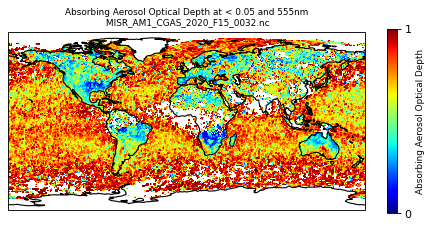

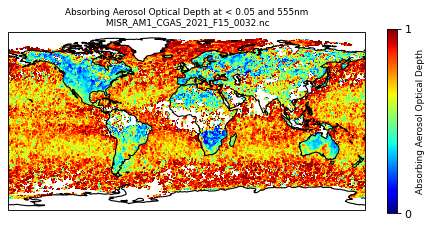

In [9]:
lon = np.linspace(-179.75, 179.75, 720)
lat = np.linspace(89.75, -89.75, 360)
proj = ccrs.PlateCarree()

for i, file in enumerate(downloaded_files):
    fig, ax = plt.subplots(figsize=(7.20, 3.60), dpi=80, subplot_kw={"projection": proj})
    ax.coastlines()

    im = ax.contourf(lon, lat, data_to_plot[i], 300, cmap="jet", transform=proj)
    plt.title(f"Absorbing Aerosol Optical Depth at < 0.05 and 555nm\n {file}", fontsize=8)

    cb = plt.colorbar(im, ticks=[0, 1], shrink=0.83)
    cb.set_label("Absorbing Aerosol Optical Depth", fontsize=8)

    plt.savefig(f"{file}.jpg", dpi=200)
    print(f"{file}.jpg")